# A Smörgåsbord of delicious new MariaDB Features


# (Optional) Follow along with your own Web Instance

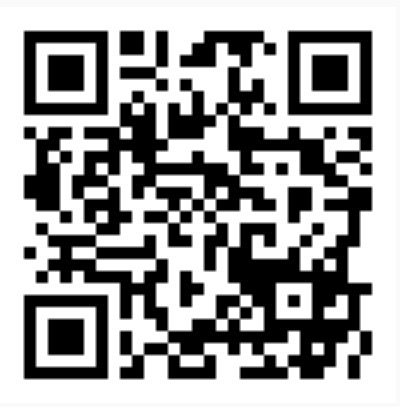

## http://tiny.cc/mariadb-fossasia2023

## New Features

New? 10.6 - GA August 2021 was until this year, the last LTS.

This talk covers 10.7+, which started GA in Feb 2022

In [ ]:
select version();

version()
10.11.2-MariaDB-1:10.11.2+maria~ubu2204


## UUID is a datatype

Added 10.7

In [ ]:
use test;
CREATE TABLE uuidt1 (id UUID);
INSERT INTO uuidt1 VALUES ('123e4567-e89b-12d3-a456-426655440000');
SELECT * FROM uuidt1;

In [ ]:
SELECT CAST(x'102030405000000000000000adcefeff' AS UUID);

In [ ]:
CREATE OR REPLACE TABLE uuidt2 (
c1 UUID DEFAULT 0x00000000000000000000000000000000,
c2 UUID DEFAULT 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,
c3 UUID DEFAULT '00000000-0000-0000-0000-000000000000',
c4 UUID DEFAULT 'ffffffff-ffff-ffff-ffff-ffffffffffff',
c5 UUID DEFAULT CAST(X'FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF' AS UUID)
);

In [ ]:
SELECT CAST('longlive-that-bear-a456-426655440000' AS UUID);

In [ ]:
SHOW WARNINGS;

Stored like a BINARY(32), looks like a string. Stored in UUIDv4 index friendly for for bulk inserting.

## INET4 data type (10.10+)

Reminder - INET6 is a 10.5+ datatype for IPv6 and IPv4

In [ ]:
create or replace table inet6_table (ip inet6);
insert into inet6_table values ("::127.0.0.1"),("2001:db8::8a2e:370:7334");
select * from inet6_table where ip="2001:0db8:0000:0000:0000:8a2e:0370:7334";

In [ ]:
create or replace table inet4_table(ip inet4);
insert into inet4_table values ('127.0.0.1'), ('192.168.0.255'), ('239.2.3.55');
select * from inet4_table;

## UCA 14.0.0 (10.10)

Unicode 14.0.0 standard from Sept 2021.

In [ ]:
SELECT * FROM INFORMATION_SCHEMA.COLLATIONS where collation_name like 'uca1400_%';

In [ ]:
create table uca14_t1 (col1 longtext character set utf8mb4 collate uca1400_croatian_ai_ci);

Note:
* as/ai - accent sensitive/ insensitive
* cs/ci - case sensitive/ insensitive


## JSON_EQUALS (10.7)

In [ ]:
SELECT JSON_EQUALS('{"a"   :[1, 2, 3],"b":[4]}', '{"b":[4],"a":[1, 2, 3.0]}');

In [ ]:

SELECT JSON_EQUALS('{"a":[1, 2, 3]}', '{"a":[3, 2, 1]}');

## JSON_NORMALIZE (10.7)
When `JSON_EQUALS(a , b)`, implies `JSON_NORMALIZE(a) == JSON_NORMALIZE(b)`.


In [ ]:
CREATE OR REPLACE TABLE json_normalize_t1 (
 id BIGINT UNSIGNED NOT NULL AUTO_INCREMENT,
 val JSON,
 PRIMARY KEY (id)
);

In [ ]:
ALTER TABLE json_normalize_t1
   ADD COLUMN jnorm JSON AS (JSON_NORMALIZE(val)) VIRTUAL,
   ADD UNIQUE KEY (jnorm);

In [ ]:
INSERT INTO json_normalize_t1 (val) VALUES ('{"name":"alice","color":"blue"}');

In [ ]:
INSERT INTO json_normalize_t1 (val) VALUES ('{ "color": "blue", "name": "alice" }');

## JSON_PRETTY

(Alias for JSON_DETAILED) - MySQL compatibility

In [ ]:
SELECT JSON_PRETTY('{ "A":1,"B":[2,3]}');

## CRC32C (10.8)

In [ ]:
SELECT CRC32C('MariaDB');

## RANDOM_BYTES (10.10)

In [ ]:
SELECT HEX(RANDOM_BYTES(100));

## JSON Histograms (10.8)

Statistical column information - for query planning.

In [ ]:
CREATE OR REPLACE TABLE JSON_HISTOGRAMS (v varchar(30));

In [ ]:
insert into JSON_HISTOGRAMS SELECT "Jane" FROM seq_1_to_20;

In [ ]:
insert into JSON_HISTOGRAMS SELECT "Bob" FROM seq_1_to_2;

In [ ]:
insert into JSON_HISTOGRAMS SELECT "Julie";

In [ ]:
SET STATEMENT histogram_type = 'JSON_HB' FOR  ANALYZE TABLE JSON_HISTOGRAMS PERSISTENT FOR ALL;

In [ ]:
SELECT * FROM mysql.column_stats;

## NATURAL_SORT_KEY (10.7)

In [ ]:
CREATE TABLE nsk_t1 (c TEXT);

In [ ]:
insert into nsk_t1 values ('b1'),('a2'),('a11'),('a1');

In [ ]:
select c from nsk_t1 order by c;

In [ ]:
select c from nsk_t1 order by natural_sort_key(c);

In [ ]:
truncate table nsk_t1;

In [ ]:
INSERT INTO nsk_t1 VALUES 
  ('5.5.31'),('10.7.0'),('10.2.1'),
  ('10.1.22'),('10.3.32'),('10.2.12');

In [ ]:
select c from nsk_t1 order by natural_sort_key(c);

In [ ]:
truncate table nsk_t1;

In [ ]:
INSERT INTO nsk_t1 VALUES 
  ('192.167.3.1'),('192.167.1.12'),('100.200.300.400'),
  ('100.50.60.70'),('100.8.9.9'),('127.0.0.1'),('0.0.0.0');

In [ ]:
select c from nsk_t1 order by natural_sort_key(c);

## SFORMAT - Python Like formatting (10.7)

In [ ]:
select sformat('The temperature is between {:-} and {:-} degrees celsius.', -3, 7);

In [ ]:
CREATE TABLE test_sformat(mdb_release char(6), mdev int, feature char(20));

In [ ]:
INSERT INTO test_sformat VALUES('10.7.0', 25015, 'Python style sformat'), 
  ('10.7.0', 4958, 'UUID');

In [ ]:

SELECT SFORMAT('MariaDB Server {} has a preview for MDEV-{} which is about {}', 
  mdb_release, mdev, feature) AS 'Preview Release Examples'
  FROM test_sformat;

## Descending Indexes (10.8.1)

In [ ]:
create or replace table desc_index_t1 (a int, b int, c int, key r (a desc, b asc));
insert desc_index_t1 select seq % 10, seq div 10, seq from seq_1_to_55;
insert desc_index_t1 values (NULL, NULL, NULL), (9, NULL, NULL);


In [ ]:

analyze format=json select * from desc_index_t1 force index(r) order by a desc,b limit 20;

In [ ]:

analyze format=json  select * from desc_index_t1 force index(r) order by a asc,b desc limit 20;

## Convert Partitions (10.7)

The previous way paritions where exchanged:

In [ ]:
CREATE OR REPLACE TABLE partitioned_table (
        dt DATETIME NOT NULL,  -- or DATE
        id int not null auto_increment,
        PRIMARY KEY (id, dt)
    )
    PARTITION BY RANGE (TO_DAYS(dt)) (
        PARTITION start        VALUES LESS THAN (0),
        PARTITION from20120315 VALUES LESS THAN (TO_DAYS('2012-03-16')),
        PARTITION from20120316 VALUES LESS THAN (TO_DAYS('2012-03-17')),
        PARTITION from20120414 VALUES LESS THAN (TO_DAYS('2012-04-15')),
        PARTITION from20120415 VALUES LESS THAN (TO_DAYS('2012-04-16'))
    );

-- create an empty non-partitioned table
CREATE OR REPLACE TABLE normal_table LIKE partitioned_table;
ALTER TABLE normal_table REMOVE PARTITIONING;

-- perform the exchange
ALTER TABLE partitioned_table EXCHANGE PARTITION start WITH TABLE normal_table;

-- and remove the now-empty partition
ALTER TABLE partitioned_table DROP PARTITION start;

Converting a table to a partition

In [ ]:
CREATE OR REPLACE TABLE normal_table (
        dt DATETIME NOT NULL,  -- or DATE
        id int not null auto_increment,
        PRIMARY KEY (id, dt)
    );
    
insert into normal_table values (now(), 1), (now(), 3);

-- create an empty partition
ALTER TABLE partitioned_table ADD PARTITION (PARTITION part1 VALUES LESS THAN (TO_DAYS('2024-04-16')));

-- perform the exchange
ALTER TABLE partitioned_table EXCHANGE PARTITION part1 WITH TABLE normal_table;

-- and remove the now-empty table
DROP TABLE normal_table;

Now with `CONVERT PARTITION` / `CONVERT TABLE`

In [ ]:
ALTER TABLE partitioned_table CONVERT PARTITION part1 TO TABLE normal_table;

In [ ]:
ALTER TABLE partitioned_table CONVERT TABLE normal_table TO PARTITION part1 VALUES LESS THAN (TO_DAYS('2024-04-16'));

## System Versioning (insert)

In [ ]:
create or replace table svt1(x int primary key) with system versioning;


In [ ]:
set @@system_versioning_insert_history= 1;

In [ ]:
show create table svt1;

In [ ]:
insert into svt1(x, row_start, row_end) values (3, '1980-01-01 00:00:00', '1980-01-01 20:00:01');


In [ ]:
select * from svt1  FOR SYSTEM_TIME  as of timestamp'1980-01-01 00:00:01';

In [ ]:
select * from svt1  FOR SYSTEM_TIME  as of timestamp'1980-01-01 20:00:02';

In [ ]:
select * from svt1  FOR SYSTEM_TIME  as of timestamp'1979-12-31 23:59:59';

## Password Reuse Plugin (10.7)

In [ ]:
INSTALL PLUGIN IF NOT EXISTS password_reuse_check SONAME 'password_reuse_check';

In [ ]:
create user pw;

In [ ]:
set password for pw = password('oh no');

In [ ]:
set password for pw = password('oh no');

## Hashicorp Key Management Plugin (10.9)

In [ ]:
install plugin if not exists hashicorp_key_management SONAME 'hashicorp_key_management';

## GET_DIAGNOSITCS (ROW_NUMBER) - 10.7+

In [ ]:
CREATE OR REPLACE TABLE gdt1 (id int not null primary key);
INSERT INTO gdt1 values(1);


In [ ]:
INSERT INTO gdt1 VALUES (4),(1),(2);

In [ ]:
GET DIAGNOSTICS CONDITION 1 @row_num= ROW_NUMBER;

In [ ]:
SELECT @row_num;

## IN/OUT/INOUT attributes on function arguments (10.8)

In [ ]:
DELIMITER $$
CREATE OR REPLACE FUNCTION add_func3(IN a INT, IN b INT, OUT c INT) RETURNS INT
BEGIN
  SET c = 100;
  RETURN a + b;
END;
$$
DELIMITER ;

In [ ]:
SET @a = 2;
SET @b = 3;
SET @c = 0;
SET @res= add_func3(@a, @b, @c);

In [ ]:
SELECT @a, @b, @c, @res;

Note: `SELECT` restriction, `OUT`/`INOUT` on `SET` only

In [ ]:
SELECT add_func3(@a, @b, @c);

## Lag free ALTER TABLE in replication (10.8)# See Pandikrishnan's talk

ALTER TABLE - pushed to replica before its finished on the master

In [ ]:
set @@binlog_alter_two_phase= ON;

## mariadb-binlog GTID support

```
$ mariadb-binlog --start-position=0-1-3  server.000001 
/*!50530 SET @@SESSION.PSEUDO_SLAVE_MODE=1*/;
/*!40019 SET @@session.max_insert_delayed_threads=0*/;
/*!50003 SET @OLD_COMPLETION_TYPE=@@COMPLETION_TYPE,COMPLETION_TYPE=0*/;
DELIMITER /*!*/;
# at 4
#230315  0:04:10 server id 1  end_log_pos 256 CRC32 0x02c62f93 	Start: binlog v 4, server v 10.8.8-MariaDB-log created 230315  0:04:10 at startup
# Warning: this binlog is either in use or was not closed properly.
ROLLBACK/*!*/;
BINLOG '
ynAQZA8BAAAA/AAAAAABAAABAAQAMTAuOC44LU1hcmlhREItbG9nAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAADKcBBkEzgNAAgAEgAEBAQEEgAA5AAEGggAAAAICAgCAAAACgoKAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAEEwQADQgICAoKCgGTL8YC
'/*!*/;
# at 256
#230315  0:04:10 server id 1  end_log_pos 285 CRC32 0xfc90805e 	Gtid list []
# at 285
#230315  0:04:10 server id 1  end_log_pos 325 CRC32 0x746763f9 	Binlog checkpoint server.000001
DELIMITER ;
# End of log file
ROLLBACK /* added by mysqlbinlog */;
/*!50003 SET COMPLETION_TYPE=@OLD_COMPLETION_TYPE*/;
/*!50530 SET @@SESSION.PSEUDO_SLAVE_MODE=0*/;
/*!100001 SET @@SESSION.SERVER_ID=@@GLOBAL.SERVER_ID */;
/*!100001 SET @@SESSION.GTID_DOMAIN_ID=@@GLOBAL.GTID_DOMAIN_ID */;
```

## CHANGE MASTER .. MASTER_DEMOTE_TO_SLAVE

```
/* STOP SLAVE; */

CHANGE MASTER TO
   MASTER_DEMOTE_TO_SLAVE = 1;
START SLAVE;
```

## GRANT  ... TO PUBLIC

(not the same as anonymous)

In [ ]:
GRANT SELECT ON test.* TO PUBLIC;

## Read only

In [ ]:
SHOW GRANTS;

In [ ]:
revoke READ ONLY ADMIN ON *.* from root@localhost;

In [ ]:
set global read_only=1; -- if a new connection had started, this would fail;

In [ ]:
set global read_only=0;

## InnoDB Fast insertion

In [ ]:
set @@foreign_key_checks=0, @@unique_checks=0;

In [ ]:
create table innodb_fast as select seq from seq_1_to_300000; -- and LOAD DATA, INSERT INTO .. VALUES  ;

## InnoDB resize undo table spaces

(Well on restart)

In [ ]:
set global innodb_undo_tablespaces=4;

## innodb_log_file_size resizable (10.9+)

In [ ]:
select @@innodb_log_file_size;

In [ ]:
set global innodb_log_file_size=128*1024*1024;

In [ ]:
select @@innodb_log_file_size;

## InnoDB Change buffer (10.9+ deprecicated and ignored), removed 11.0

InnoDB change buffer: Unsafe at any speed -https://fosdem.org/2023/schedule/event/innodb_change_buffer/

## Apostrophes in FT search

In [ ]:
CREATE TABLE ftt1(f1 TINYTEXT NOT NULL, FULLTEXT(f1))ENGINE=InnoDB;
INSERT INTO ftt1 VALUES('O''Brien'), ('O Brien'), ('Ö''Brien');
INSERT INTO ftt1 VALUES('Brien'), ('O ''Brien'), ('O'' Brien');
INSERT INTO ftt1 VALUES('Doh''nuts');


In [ ]:
SELECT * FROM ftt1 WHERE MATCH (f1) AGAINST ("+O'Brien" IN BOOLEAN MODE);


In [ ]:
SELECT * FROM ftt1 WHERE MATCH (f1) AGAINST ("+Doh'nuts" IN BOOLEAN MODE);


In [ ]:
SELECT * FROM ftt1 WHERE MATCH (f1) AGAINST ("+Ö''Brien" IN BOOLEAN MODE);


## innodb buffer pool soft decommit of memory

```code:c++
@@ -1024,7 +1017,7 @@ buf_LRU_block_free_non_file_page(
 		pthread_cond_signal(&buf_pool.done_free);
 	}
 
-	MEM_NOACCESS(block->page.frame, srv_page_size);
+	block->page.set_os_unused();
 }
 
 /** Release a memory block to the buffer pool. */
diff --git a/storage/innobase/include/buf0buf.h b/storage/innobase/include/buf0buf.h
index 24571483d05c5..2dd6935241e32 100644
--- a/storage/innobase/include/buf0buf.h
+++ b/storage/innobase/include/buf0buf.h
@@ -657,6 +657,20 @@ class buf_page_t
     access_time= 0;
   }
 
+  void set_os_unused()
+  {
+    MEM_NOACCESS(frame, srv_page_size);
+#ifdef MADV_FREE
+    madvise(frame, srv_page_size, MADV_FREE);
+#endif
+  }
+
+  void set_os_used() const
+  {
+    MEM_MAKE_ADDRESSABLE(frame, srv_page_size);
+  }
 public:
   const page_id_t &id() const { return id_; }
   uint32_t state() const { return zip.fix; }
```

## System Versioning - auto

In [ ]:
CREATE TABLE sv_autot1 (x int) WITH SYSTEM VERSIONING
    PARTITION BY SYSTEM_TIME INTERVAL 1 HOUR AUTO;

In [ ]:

CREATE TABLE sv_autot2 (x int) WITH SYSTEM VERSIONING
   PARTITION BY SYSTEM_TIME INTERVAL 1 MONTH
   STARTS '2021-01-01 00:00:00' AUTO PARTITIONS 12;

In [ ]:
CREATE TABLE sv_autot3 (x int) WITH SYSTEM VERSIONING
  PARTITION BY SYSTEM_TIME LIMIT 1000 AUTO;


## mariadb-dump --order-by-size

small tables first.

a avoids "Table definition has changed, please retry transaction' error" error when ALTER TABLE Issues during backup, meaning less likely to impact data is saved first.

## Chinese Error messages (and default in China mainland locale)

In [ ]:
SET lc_messages=ZH_CN;